# vLLM Qwen1.5-72B-Chat-AWQ vLLM deployment guide
In this tutorial, you will use LMI container from DLC to SageMaker and run inference with it.

Please make sure the following permission granted before running the notebook:

- S3 bucket push access
- SageMaker access

## Step 1: Let's bump up SageMaker and import stuff

In [6]:
%pip install sagemaker --upgrade  --quiet
%pip install boto3==1.34.101

Note: you may need to restart the kernel to use updated packages.
  Using cached boto3-1.34.101-py3-none-any.whl.metadata (6.6 kB)
Using cached boto3-1.34.101-py3-none-any.whl (139 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.51
    Uninstalling botocore-1.34.51:
      Successfully uninstalled botocore-1.34.51
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.51
    Uninstalling boto3-1.34.51:
      Successfully uninstalled boto3-1.34.51
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.1 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.34.113 which is incompatible.
amazon-sagemaker-jupyter-scheduler 3.0.7 requires jupyter-scheduler==2.5, but you have jupyter-scheduler 2.5.1 which is i

In [1]:
import boto3
import sagemaker
from sagemaker import Model, image_uris, serializers, deserializers

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()  # account_id of the current SageMaker Studio environment

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Step 2: Start preparing model artifacts
In LMI contianer, we expect some artifacts to help setting up the model
- serving.properties (required): Defines the model server settings
- model.py (optional): A python file to define the core inference logic
- requirements.txt (optional): Any additional pip wheel need to install

In [30]:
%%writefile serving.properties
engine=Python
option.model_id=01-ai/Yi-1.5-34B-Chat
option.task=text-generation
option.trust_remote_code=true
option.tensor_parallel_degree=4
option.rolling_batch=vllm
option.dtype=fp16
option.max_rolling_batch_size=32
option.max_model_len=4096

Writing serving.properties


In [31]:
%%sh
mkdir mymodel
mv serving.properties mymodel/
tar czvf mymodel.tar.gz mymodel/
rm -rf mymodel

mymodel/
mymodel/serving.properties


## Step 3: Start building SageMaker endpoint
In this step, we will build SageMaker endpoint from scratch

### Getting the container image URI

[Large Model Inference available DLC](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers)


In [32]:
image_uri = image_uris.retrieve(
        framework="djl-deepspeed",
        region=sess.boto_session.region_name,
        version="0.27.0"
    )

### Upload artifact on S3 and create SageMaker model

In [33]:
s3_code_prefix = "large-model-lmi/code-yi1.5-34B"
bucket = sess.default_bucket()  # bucket to house artifacts
code_artifact = sess.upload_data("mymodel.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact}")

model = Model(image_uri=image_uri, model_data=code_artifact, role=role)

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-434444145045/large-model-lmi/code-yi1.5-34B/mymodel.tar.gz


### 4.2 Create SageMaker endpoint

You need to specify the instance to use and endpoint names

In [34]:
instance_type = "ml.g5.12xlarge"
endpoint_name = sagemaker.utils.name_from_base("lmi-model-yi15-34B")

model.deploy(initial_instance_count=1,
             instance_type=instance_type,
             endpoint_name=endpoint_name,
             # container_startup_health_check_timeout=3600
            )



-------------!

In [35]:
# endpoint_name = 'lmi-model-qwen1-5-72B-2024-05-23-09-10-23-101'
print(endpoint_name)

lmi-model-yi15-34B-2024-05-27-06-44-15-037


In [36]:
# our requests and responses will be in json format so we specify the serializer and the deserializer
predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

## Step 5: Test and benchmark the inference

## Performance test

In [26]:
%pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [37]:
from transformers import AutoTokenizer

MODEL_DIR = '01-ai/Yi-1.5-34B-Chat'
# model = AutoModelForCausalLM.from_pretrained(MODEL_DIR, torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=False)

import json
messages = [
    {"role": "user", "content": "世界上第二高的山峰是哪座"},
    {"role": "assistant", "content": "世界上第二高的山峰是中国的珠穆朗玛峰。珠穆朗玛峰位于中国西藏自治区南部边境与尼泊尔交界的喜马拉雅山脉中，海拔高度为8848.86米（29,029英尺）。它是世界上海拔最高的山脉，同时也是中国大陆的最高峰。\\n\\n珠穆朗玛峰的名字来源于藏语，“珠穆”意为女神，“朗玛”意为母仪天下，整体意为“大地之母”。这座山峰不仅在登山界享有盛誉，也是全球登山爱好者和探险"},
    {"role": "user", "content": "一个句子总结"}
    
]

input_text = tokenizer.apply_chat_template(conversation=messages, tokenize=False, add_generation_prompt=True)
print(json.dumps(input_text, ensure_ascii=False))

"<|im_start|>user\n世界上第二高的山峰是哪座<|im_end|>\n<|im_start|>assistant\n世界上第二高的山峰是中国的珠穆朗玛峰。珠穆朗玛峰位于中国西藏自治区南部边境与尼泊尔交界的喜马拉雅山脉中，海拔高度为8848.86米（29,029英尺）。它是世界上海拔最高的山脉，同时也是中国大陆的最高峰。\\n\\n珠穆朗玛峰的名字来源于藏语，“珠穆”意为女神，“朗玛”意为母仪天下，整体意为“大地之母”。这座山峰不仅在登山界享有盛誉，也是全球登山爱好者和探险<|im_end|>\n<|im_start|>user\n一个句子总结<|im_end|>\n<|im_start|>assistant\n"


In [38]:
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig
import time

In [39]:
text1 = \
"""你是一名小说家，热衷于创意写作和编写故事。 
请帮我编写一个故事，对象是10-12岁的小学生
故事背景：
讲述一位名叫莉拉的年轻女子发现自己有控制天气的能力。她住在一个小镇上，每个人都互相认识。
其他要求：
-避免暴力，色情，粗俗的语言
-长度要求不少于500字
请开始：
"""

In [40]:
max_new_tokens = 256
def invoke_sagemaker(prompt,max_new_tokens):
    # print('----start----')
    messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    parameters = {
            "max_new_tokens":max_new_tokens, 
            "do_sample": True,
            "repetition_penalty": 1.05,
            "temperature": 0.7,
            "top_p": 0.8,
            "top_k": 250
        }
    t1 =  time.time()
    response = predictor.predict(
        {"inputs": inputs, "parameters": parameters}
    )
    t2 = time.time() - t1
    return response['generated_text'],t2
    

In [41]:
import math
def list_stats(lst):
    # Calculate the maximum value
    max_val = max(lst)

    # Calculate the average value
    avg_val = sum(lst) / len(lst)

    # Sort the list to find the median
    sorted_lst = sorted(lst)
    n = len(sorted_lst)
    # Calculate the median value
    if n % 2 == 0:
        # If the list has an even number of elements
        median_val = (sorted_lst[n // 2 - 1] + sorted_lst[n // 2]) / 2
    else:
        # If the list has an odd number of elements
        median_val = sorted_lst[n // 2]

    p90_index = int(math.ceil(0.9 * n)) - 1
    p90_val = sorted_lst[p90_index]
    
    return max_val, avg_val, median_val,p90_val
my_list = [5, 2, 8, 1, 9, 3]
max_val, avg_val, median_val,p90_val = list_stats(my_list)
print("Maximum value:", max_val)
print("Average value:", avg_val)
print("Median value:", median_val)
print("p90_val value:", p90_val)

Maximum value: 9
Average value: 4.666666666666667
Median value: 4.0
p90_val value: 9


In [42]:
chain = RunnableLambda(invoke_sagemaker).bind(max_new_tokens=max_new_tokens)

In [43]:
chain.batch([text1],config=config)

[('在一个被连绵山脉环抱的小镇，莉拉与她的祖父一同居住。这个镇上的人们彼此熟识，生活节奏悠然自得。莉拉是个好奇心旺盛的少女，她总是梦想着探索未知的奥秘。\n\n某天，莉拉在森林中漫步时，突然乌云密布，一场暴风雨即将来临。正当她急忙找寻避雨之处时，她发现自己竟能控制天气。她轻轻地挥动手臂，乌云便散去了，阳光再次洒满大地。这让她感到既惊奇又害怕。\n\n消息传遍了整个小镇，人们对此议论纷纷。有的认为这是奇迹，有的则觉得这是一种威胁。莉拉试图隐藏自己的能力，但不可避免地在一次偶然的机会中展示了出来。\n\n那是一个炎热的夏日午后，镇上的孩子们在河边玩耍。突然，河水上涨，一场突如其来的洪水威胁到了他们的安全。莉拉见状，毫不犹豫地使用她的力量，召唤来一阵清风，将孩子们安全地带离了危险。\n\n从此，莉拉成为了镇上的守护者。她学会了如何控制自己的力量，不仅保护了小镇免受自然灾害的侵袭，还帮助村民们解决了许多问题。无论是',
  11.953031063079834)]

In [44]:
concurrent = [1,5,10,15,20,25,30,35,40,45,50]
config = RunnableConfig(max_concurrency=max(concurrent))

In [45]:
results = []
for n in concurrent:
    res = chain.batch([text1]*n,config=config)
    cost_lst = [ r[1] for r in res]
    max_val, avg_val, median_val,p90_val = list_stats(cost_lst)
    results.append([n,max_val, avg_val, median_val,p90_val,max_new_tokens/avg_val,n*max_new_tokens/avg_val])
    print(f'concurrent users:{n}, max time cost:{max_val:.2f}, average time cost:{avg_val:.2f}, median cost:{median_val:.2f}, avg tokens/s:{max_new_tokens/avg_val:.2f},total avg throughput:{n*max_new_tokens/avg_val:.2f}')

concurrent users:1, max time cost:11.77, average time cost:11.77, median cost:11.77, avg tokens/s:21.76,total avg throughput:21.76
concurrent users:5, max time cost:14.49, average time cost:14.48, median cost:14.48, avg tokens/s:17.68,total avg throughput:88.39
concurrent users:10, max time cost:16.65, average time cost:16.63, median cost:16.63, avg tokens/s:15.39,total avg throughput:153.91
concurrent users:15, max time cost:17.39, average time cost:17.35, median cost:17.36, avg tokens/s:14.75,total avg throughput:221.28
concurrent users:20, max time cost:19.25, average time cost:19.21, median cost:19.22, avg tokens/s:13.33,total avg throughput:266.59
concurrent users:25, max time cost:20.90, average time cost:20.83, median cost:20.85, avg tokens/s:12.29,total avg throughput:307.29
concurrent users:30, max time cost:21.69, average time cost:21.56, median cost:21.59, avg tokens/s:11.87,total avg throughput:356.23
concurrent users:35, max time cost:34.32, average time cost:22.92, median

In [46]:
import pandas as pd
pd.DataFrame(results,columns=['concurrency','max_latency','avg_latency','p50_latency','p90_latency','avg_tokens/s','avg_throughput tokens/s'])

,concurrency,max_latency,avg_latency,p50_latency,p90_latency,avg_tokens/s,avg_throughput tokens/s
0,1,11.766905,11.766905,11.766905,11.766905,21.755934,21.755934
1,5,14.493925,14.481182,14.484469,14.493925,17.678114,88.390572
2,10,16.652424,16.632565,16.630852,16.647479,15.391492,153.914922
3,15,17.392326,17.353449,17.357088,17.388788,14.752111,221.281663
4,20,19.253440,19.205175,19.221762,19.242933,13.329740,266.594807
5,25,20.900777,20.827110,20.854147,20.890134,12.291672,307.291801
6,30,21.694034,21.559359,21.591933,21.675483,11.874193,356.225800
7,35,34.322465,22.918862,21.942166,22.002966,11.169839,390.944364
8,40,36.495482,24.789393,21.960599,36.458731,10.326997,413.079897
9,45,38.636347,26.676410,21.950826,38.567999,9.596494,431.842218


In [47]:
import matplotlib.pyplot as plt

In [48]:
# 从二维数组中提取列
x = [row[0] for row in results]  
y1 = [row[1] for row in results]  
y2 = [row[2] for row in results]  
y3 = [row[3] for row in results]  
y4 = [row[4] for row in results]  
y5 = [row[5] for row in results]  
y6 = [row[6] for row in results]  

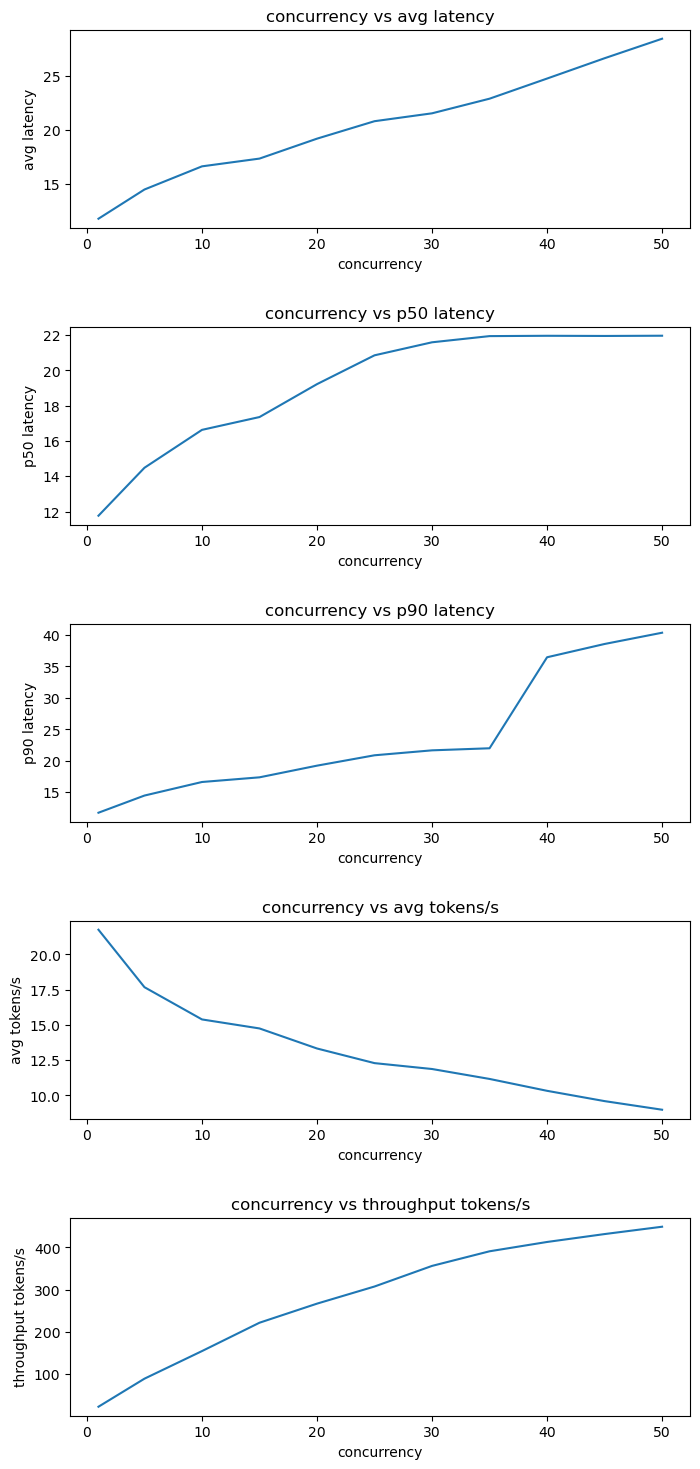

In [49]:
# 创建图形
fig, axs = plt.subplots(5, 1, figsize=(8, 18))

# 绘制第avg timecost
axs[0].plot(x, y2)
axs[0].set_title('concurrency vs avg latency')
axs[0].set_xlabel('concurrency')
axs[0].set_ylabel('avg latency')

# 绘制第一列与第三列的关系
axs[1].plot(x, y3)
axs[1].set_title('concurrency vs p50 latency')
axs[1].set_xlabel('concurrency')
axs[1].set_ylabel('p50 latency')

# 绘制第一列与第四列的关系
axs[2].plot(x, y4)
axs[2].set_title('concurrency vs p90 latency')
axs[2].set_xlabel('concurrency')
axs[2].set_ylabel('p90 latency')

# 绘制第一列与第四列的关系
axs[3].plot(x, y5)
axs[3].set_title('concurrency vs avg tokens/s')
axs[3].set_xlabel('concurrency')
axs[3].set_ylabel('avg tokens/s')


# 绘制第一列与第四列的关系
axs[4].plot(x, y6)
axs[4].set_title('concurrency vs throughput tokens/s')
axs[4].set_xlabel('concurrency')
axs[4].set_ylabel('throughput tokens/s')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 显示图形
plt.show()

## Clean up the environment

In [29]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
model.delete_model()